In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 67.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import xml.etree.ElementTree as ET
from scipy.signal import butter, lfilter, resample
import mne
import cv2

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

def downsample(data, original_fs, target_fs):
    factor = int(original_fs / target_fs)
    return resample(data, len(data) // factor)

def preprocess_ecg(raw, target_fs=128, fixed_length=512):
    exg_channels = ['EXG1', 'EXG2']
    try:
        exg_data = raw.get_data(picks=exg_channels)
        original_fs = raw.info['sfreq']

        # Process each EXG channel
        filtered_data = []
        for i, channel in enumerate(exg_data):
            filtered = bandpass_filter(channel, lowcut=0.5, highcut=40, fs=original_fs)
            filtered_data.append(filtered)

        exg_data = np.array(filtered_data)

        # Downsample
        exg_data = np.array([downsample(channel, original_fs, target_fs)
                            for channel in exg_data])

        # Normalize
        exg_data = (exg_data - np.mean(exg_data, axis=1, keepdims=True)) / \
                   (np.std(exg_data, axis=1, keepdims=True) + 1e-10)

        # Remove artifacts
        exg_data = np.clip(exg_data, -5, 5)

        # Pad or truncate
        exg_data = np.array([np.pad(channel,
                                   (0, max(0, fixed_length - len(channel))),
                                   'constant')[:fixed_length]
                            for channel in exg_data])

        return exg_data
    except Exception as e:
        print(f"Error processing ECG signals: {e}")
        return None

def preprocess_bdf(file_path, selected_channels, lowcut=4, highcut=45, target_fs=128, fixed_length=512):
    raw = mne.io.read_raw_bdf(file_path, preload=True, verbose=False)

    # Process EEG
    channel_indices = [raw.ch_names.index(ch) for ch in selected_channels]
    eeg_data = raw.get_data(picks=channel_indices)
    original_fs = raw.info['sfreq']

    # Bandpass filter EEG
    eeg_data = np.array([bandpass_filter(channel, lowcut, highcut, original_fs)
                        for channel in eeg_data])
    # Downsample EEG
    eeg_data = np.array([downsample(channel, original_fs, target_fs)
                        for channel in eeg_data])
    # Normalize EEG
    eeg_data = (eeg_data - np.mean(eeg_data, axis=1, keepdims=True)) / \
               np.std(eeg_data, axis=1, keepdims=True)
    # Pad or truncate EEG
    eeg_data = np.array([np.pad(channel,
                               (0, max(0, fixed_length - len(channel))),
                               'constant')[:fixed_length]
                        for channel in eeg_data])

    # Process ECG signals
    ecg_data = preprocess_ecg(raw, target_fs=target_fs, fixed_length=fixed_length)

    return eeg_data, ecg_data

def preprocess_avi(file_path, frame_size=(64, 64), fixed_frames=32):
    cap = cv2.VideoCapture(file_path)
    video_features = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, frame_size)
        video_features.append(frame)

    cap.release()
    video_features = np.array(video_features)

    num_frames = len(video_features)
    if num_frames < fixed_frames:
        padding = np.zeros((fixed_frames - num_frames, *frame_size), dtype=np.uint8)
        video_features = np.vstack((video_features, padding))
    else:
        video_features = video_features[:fixed_frames]

    return video_features

def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    felt_emo = int(root.get('feltEmo', 0))
    felt_arsl = float(root.get('feltArsl', 0.0))
    felt_vlnc = float(root.get('feltVlnc', 0.0))

    metadata = {child.tag: child.text for child in root}
    return felt_emo, felt_arsl, felt_vlnc, metadata

def process_dataset(base_folder, selected_channels, lowcut=4, highcut=45, target_fs=128, frame_size=(64, 64), save_folder="preprocessed_data"):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    dataset = []
    processed_count = 0

    for root, _, files in os.walk(base_folder):
        session_files = {'bdf': None, 'avi': None, 'xml': None}
        base_names = set()

        for file in files:
            if file.endswith('.bdf'):
                session_files['bdf'] = os.path.join(root, file)
                base_names.add(os.path.splitext(file)[0])
            elif file.endswith('.avi'):
                session_files['avi'] = os.path.join(root, file)
                base_names.add(os.path.splitext(file)[0])
            elif file.endswith('.xml'):
                session_files['xml'] = os.path.join(root, file)
                base_names.add(os.path.splitext(file)[0])

        for base_name in base_names:
            if all(session_files.values()):
                eeg_data, ecg_data = preprocess_bdf(session_files['bdf'],
                                                   selected_channels, lowcut,
                                                   highcut, target_fs)
                video_data = preprocess_avi(session_files['avi'], frame_size)
                felt_emo, felt_arsl, felt_vlnc, metadata = parse_xml(session_files['xml'])

                dataset_entry = {
                    'eeg_data': eeg_data,
                    'ecg_data': ecg_data,
                    'video_data': video_data,
                    'labels': [felt_emo, felt_arsl, felt_vlnc],
                    'metadata': metadata
                }
                dataset.append(dataset_entry)
                processed_count += 1

                print(f"Processed {processed_count}: {base_name}")

    save_path = os.path.join(save_folder, "mahnob_HCI_preprocessed_all.npy")
    np.save(save_path, dataset)

    return dataset

# Define preprocessing parameters
base_folder = '/content/drive/MyDrive/dataset/mahnob-hci'
save_folder = '/content/drive/MyDrive/dataset/preprocessed-data'
selected_channels = ['P3', 'FC2', 'AF3', 'O1', 'Fp1']
lowcut = 4
highcut = 45
target_fs = 128
frame_size = (64, 64)

# Process the dataset
process_dataset(base_folder, selected_channels, lowcut, highcut, target_fs, frame_size, save_folder)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv3D, MaxPooling3D, Flatten, Dense, LSTM, Dropout,
                                   Concatenate, BatchNormalization, ZeroPadding3D)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load and duplicate dataset
data_path = '/content/drive/MyDrive/dataset/preprocessed-data/mahnob_HCI_preprocessed_all.npy'
data = np.load(data_path, allow_pickle=True)

def duplicate_dataset(data, num_duplicates):
    duplicated_data = data.tolist()
    for _ in range(num_duplicates):
        duplicated_data.extend(data.tolist())
    return np.array(duplicated_data)

# Duplicate dataset
num_duplicates = 2
data = duplicate_dataset(data, num_duplicates)

# Extract features and labels
X_eeg = np.array([entry['eeg_data'] for entry in data])
X_video = np.array([entry['video_data'] for entry in data])
X_ecg = np.array([entry['ecg_data'] for entry in data])
y = np.array([entry['labels'] for entry in data])

print(f"Number of samples after duplication: {len(data)}")

# Pad video data if needed
if X_video.shape[1:] != (32, 64, 64):
    padded_video = []
    for video in X_video:
        pad_shape = [
            (0, max(0, 32 - video.shape[0])),
            (0, max(0, 64 - video.shape[1])),
            (0, max(0, 64 - video.shape[2]))
        ]
        padded_video.append(np.pad(video, pad_shape, mode='constant'))
    X_video = np.array(padded_video)

# Modified balance_classes function for three modalities
def balance_classes(X1, X2, X3, y, class_idx):
    labels = y[:, class_idx]
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    max_count = np.max(class_counts)

    balanced_X1, balanced_X2, balanced_X3, balanced_y = [], [], [], []
    for cls in unique_classes:
        cls_mask = labels == cls
        cls_X1, cls_X2, cls_X3, cls_y = X1[cls_mask], X2[cls_mask], X3[cls_mask], y[cls_mask]

        if len(cls_y) < max_count:
            X1_oversampled, X2_oversampled, X3_oversampled, y_oversampled = resample(
                cls_X1, cls_X2, cls_X3, cls_y,
                replace=True,
                n_samples=max_count - len(cls_y),
                random_state=42
            )
            cls_X1 = np.concatenate([cls_X1, X1_oversampled])
            cls_X2 = np.concatenate([cls_X2, X2_oversampled])
            cls_X3 = np.concatenate([cls_X3, X3_oversampled])
            cls_y = np.concatenate([cls_y, y_oversampled])

        balanced_X1.append(cls_X1)
        balanced_X2.append(cls_X2)
        balanced_X3.append(cls_X3)
        balanced_y.append(cls_y)

    return (np.concatenate(balanced_X1),
            np.concatenate(balanced_X2),
            np.concatenate(balanced_X3),
            np.concatenate(balanced_y))

# Balance classes
X_eeg, X_video, X_ecg, y = balance_classes(X_eeg, X_video, X_ecg, y, class_idx=1)
X_eeg, X_video, X_ecg, y = balance_classes(X_eeg, X_video, X_ecg, y, class_idx=2)

# Split data
X_eeg_train, X_eeg_test, X_video_train, X_video_test, X_ecg_train, X_ecg_test, y_train, y_test = train_test_split(
    X_eeg, X_video, X_ecg, y, test_size=0.2, random_state=42
)

# Prepare labels
num_valence_classes = int(np.max(y[:, 1])) + 1
num_arousal_classes = int(np.max(y[:, 2])) + 1

y_valence_train = to_categorical(y_train[:, 1], num_classes=num_valence_classes)
y_arousal_train = to_categorical(y_train[:, 2], num_classes=num_arousal_classes)
y_valence_test = to_categorical(y_test[:, 1], num_classes=num_valence_classes)
y_arousal_test = to_categorical(y_test[:, 2], num_classes=num_arousal_classes)

# Model Definition
# 1. Video Branch
video_input = Input(shape=(32, 64, 64, 1), name="video_input")
cnn = ZeroPadding3D(padding=(1, 1, 1))(video_input)
cnn = Conv3D(32, (3, 3, 3), activation='relu')(cnn)
cnn = MaxPooling3D((2, 2, 2))(cnn)
cnn = BatchNormalization()(cnn)
cnn = Conv3D(64, (3, 3, 3), activation='relu')(cnn)
cnn = MaxPooling3D((2, 2, 2))(cnn)
cnn = BatchNormalization()(cnn)
cnn = Flatten()(cnn)
cnn_output = Dense(128, activation='relu')(cnn)

# 2. EEG Branch
eeg_input = Input(shape=(5, 512), name="eeg_input")
lstm_eeg = LSTM(128, return_sequences=True)(eeg_input)
lstm_eeg = Dropout(0.2)(lstm_eeg)
lstm_eeg = LSTM(64)(lstm_eeg)
lstm_eeg_output = Dense(128, activation='relu')(lstm_eeg)

# 3. ECG Branch
ecg_input = Input(shape=(2, 512), name="ecg_input")
lstm_ecg = LSTM(64, return_sequences=True)(ecg_input)
lstm_ecg = Dropout(0.2)(lstm_ecg)
lstm_ecg = LSTM(32)(lstm_ecg)
lstm_ecg_output = Dense(64, activation='relu')(lstm_ecg)

# Combine all modalities
combined = Concatenate()([cnn_output, lstm_eeg_output, lstm_ecg_output])
combined = Dense(256, activation='relu')(combined)
combined = Dropout(0.3)(combined)
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.2)(combined)

# Output layers
valence_output = Dense(num_valence_classes, activation='softmax', name="valence_output")(combined)
arousal_output = Dense(num_arousal_classes, activation='softmax', name="arousal_output")(combined)

# Create and compile model
model = Model(
    inputs=[video_input, eeg_input, ecg_input],
    outputs=[valence_output, arousal_output]
)

model.compile(
    optimizer='adam',
    loss=['categorical_crossentropy', 'categorical_crossentropy'],
    metrics=['accuracy','accuracy']
)

model.summary()

# Train model
history = model.fit(
    [X_video_train[..., np.newaxis], X_eeg_train, X_ecg_train],
    [y_valence_train, y_arousal_train],
    validation_data=(
        [X_video_test[..., np.newaxis], X_eeg_test, X_ecg_test],
        [y_valence_test, y_arousal_test]
    ),
    epochs=50,
    batch_size=128
)

# Evaluate model
y_valence_pred, y_arousal_pred = model.predict([X_video_test[..., np.newaxis], X_eeg_test, X_ecg_test])

# Calculate metrics
y_valence_pred_classes = np.argmax(y_valence_pred, axis=1)
y_arousal_pred_classes = np.argmax(y_arousal_pred, axis=1)
y_valence_true = np.argmax(y_valence_test, axis=1)
y_arousal_true = np.argmax(y_arousal_test, axis=1)

valence_accuracy = accuracy_score(y_valence_true, y_valence_pred_classes)
arousal_accuracy = accuracy_score(y_arousal_true, y_arousal_pred_classes)

print(f"Valence Accuracy: {valence_accuracy * 100:.2f}%")
print(f"Arousal Accuracy: {arousal_accuracy * 100:.2f}%")


Number of samples after duplication: 558


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ video_input (InputLayer)  │ (None, 32, 64, 64, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding3d_1          │ (None, 34, 66, 66, 1)  │              0 │ video_input[0][0]      │
│ (ZeroPadding3D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 32, 64, 64, 32) │            896 │ zero_padding3d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 16, 32, 32, 32) │              0 │ conv3d_2[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 32, 32, 32) │            128 │ max_pooling3d_2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 14, 30, 30, 64) │         55,360 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ eeg_input (InputLayer)    │ (None, 5, 512)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ecg_input (InputLayer)    │ (None, 2, 512)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_3           │ (None, 7, 15, 15, 64)  │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 5, 128)         │        328,192 │ eeg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 2, 64)          │        147,712 │ ecg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 7, 15, 15, 64)  │            256 │ max_pooling3d_3[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 5, 128)         │              0 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 2, 64)          │              0 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 100800)         │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 64)             │         49,408 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 32)             │         12,416 │ dropout_5[0][0]        │
├──────────────────────

 Total params: 13,624,980 (51.98 MB)

 Trainable params: 13,624,788 (51.97 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 720ms/step - arousal_output_accuracy: 0.1353 - arousal_output_loss: 7.9933 - loss: 14.5558 - valence_output_accuracy: 0.1630 - valence_output_loss: 6.4557 - val_arousal_output_accuracy: 0.1115 - val_arousal_output_loss: 51.7030 - val_loss: 91.7672 - val_valence_output_accuracy: 0.1022 - val_valence_output_loss: 41.4912
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 624ms/step - arousal_output_accuracy: 0.1665 - arousal_output_loss: 2.2393 - loss: 4.4804 - valence_output_accuracy: 0.1923 - valence_output_loss: 2.2321 - val_arousal_output_accuracy: 0.1115 - val_arousal_output_loss: 36.9179 - val_loss: 67.1577 - val_valence_output_accuracy: 0.1393 - val_valence_output_loss: 31.4028
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 638ms/step - arousal_output_accuracy: 0.1993 - arousal_output_loss: 2.1873 - loss: 4.2603 - valence_output_accuracy: 0.2484 - valence_output_loss: 2.0693 - val_arousal_output_accuracy: 0.1053 - val_arousal_output_loss: 17.6568 - val_l

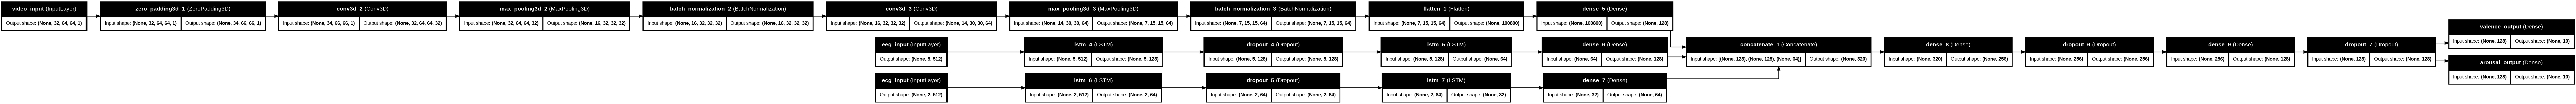

In [ ]:
from tensorflow.keras.utils import plot_model
import graphviz
from IPython.display import Image

# Generate the model visualization
plot_model(model,
          to_file='multimodal_model.png',
          show_shapes=True,
          show_layer_names=True,
          rankdir='LR',
          show_dtype=False,
          dpi=96)

# Display the image
Image('multimodal_model.png')


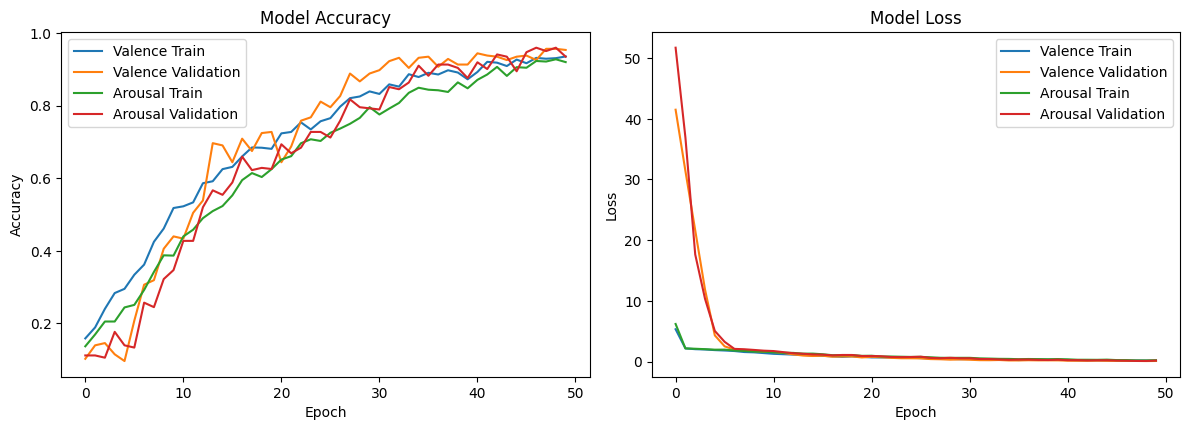


Classification Report for Valence:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        29
           2       1.00      0.94      0.97        34
           3       0.82      0.93      0.87        29
           4       1.00      0.93      0.97        30
           5       0.96      1.00      0.98        45
           6       0.84      0.90      0.87        41
           7       1.00      0.86      0.93        36
           8       1.00      1.00      1.00        48
           9       1.00      1.00      1.00        31

    accuracy                           0.95       323
   macro avg       0.96      0.95      0.95       323
weighted avg       0.96      0.95      0.95       323


Classification Report for Arousal:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        36
           2       0.87      0.87      0.87        39
           3       0.76      1.00      0.86        38
      

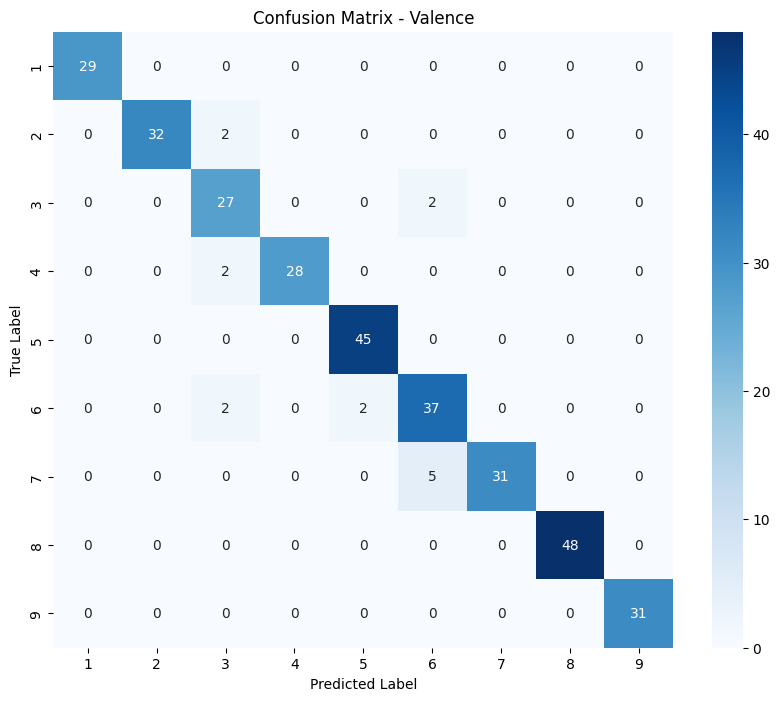


Confusion Matrix for Arousal:


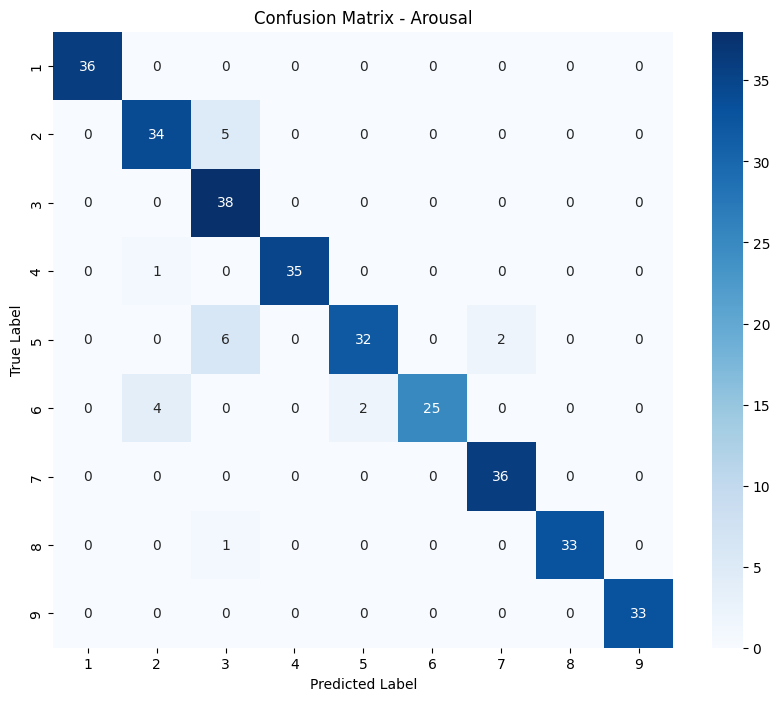


Valence Confusion Matrix:
[[29  0  0  0  0  0  0  0  0]
 [ 0 32  2  0  0  0  0  0  0]
 [ 0  0 27  0  0  2  0  0  0]
 [ 0  0  2 28  0  0  0  0  0]
 [ 0  0  0  0 45  0  0  0  0]
 [ 0  0  2  0  2 37  0  0  0]
 [ 0  0  0  0  0  5 31  0  0]
 [ 0  0  0  0  0  0  0 48  0]
 [ 0  0  0  0  0  0  0  0 31]]

Arousal Confusion Matrix:
[[36  0  0  0  0  0  0  0  0]
 [ 0 34  5  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0]
 [ 0  1  0 35  0  0  0  0  0]
 [ 0  0  6  0 32  0  2  0  0]
 [ 0  4  0  0  2 25  0  0  0]
 [ 0  0  0  0  0  0 36  0  0]
 [ 0  0  1  0  0  0  0 33  0]
 [ 0  0  0  0  0  0  0  0 33]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Plot training history
plt.figure(figsize=(12, 8))

# Training and validation accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['valence_output_accuracy'], label='Valence Train')
plt.plot(history.history['val_valence_output_accuracy'], label='Valence Validation')
plt.plot(history.history['arousal_output_accuracy'], label='Arousal Train')
plt.plot(history.history['val_arousal_output_accuracy'], label='Arousal Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Training and validation loss
plt.subplot(2, 2, 2)
plt.plot(history.history['valence_output_loss'], label='Valence Train')
plt.plot(history.history['val_valence_output_loss'], label='Valence Validation')
plt.plot(history.history['arousal_output_loss'], label='Arousal Train')
plt.plot(history.history['val_arousal_output_loss'], label='Arousal Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print classification reports
print("\nClassification Report for Valence:")
print(classification_report(y_valence_true, y_valence_pred_classes))

print("\nClassification Report for Arousal:")
print(classification_report(y_arousal_true, y_arousal_pred_classes))

# Plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    # Adjust ticks to show class numbers starting from 1
    plt.xticks(np.arange(0.5, len(np.unique(y_true)) + 0.5),
               range(1, len(np.unique(y_true)) + 1))
    plt.yticks(np.arange(0.5, len(np.unique(y_true)) + 0.5),
               range(1, len(np.unique(y_true)) + 1))
    plt.show()

# Plot confusion matrices
print("\nConfusion Matrix for Valence:")
plot_confusion_matrix(y_valence_true, y_valence_pred_classes, "Confusion Matrix - Valence")

print("\nConfusion Matrix for Arousal:")
plot_confusion_matrix(y_arousal_true, y_arousal_pred_classes, "Confusion Matrix - Arousal")

# Print confusion matrices as text
print("\nValence Confusion Matrix:")
print(confusion_matrix(y_valence_true, y_valence_pred_classes))

print("\nArousal Confusion Matrix:")
print(confusion_matrix(y_arousal_true, y_arousal_pred_classes))


In [ ]:
import numpy as np

class EmotionFuzzifier:
    def __init__(self):
        # Define membership function ranges for valence and arousal (1-9 scale)
        self.valence_ranges = {
            'negative': [1, 3, 5],
            'neutral': [4, 5, 6],
            'positive': [5, 7, 9]
        }

        self.arousal_ranges = {
            'low': [1, 3, 5],
            'neutral': [4, 5, 6],
            'high': [5, 7, 9]
        }

    def triangular_mf(self, x, a, b, c):
        """Triangular membership function"""
        return max(min((x-a)/(b-a), (c-x)/(c-b)), 0)

    def get_membership_degrees(self, value, ranges):
        """Calculate membership degrees for a value"""
        degrees = {}
        for label, (a, b, c) in ranges.items():
            degrees[label] = self.triangular_mf(value, a, b, c)
        return degrees

    def apply_fuzzy_rules(self, valence_mb, arousal_mb):
        """Apply fuzzy rules to determine emotions"""
        emotion_degrees = {
            'Excited': min(valence_mb['positive'], arousal_mb['high']),
            'Delighted': min(valence_mb['positive'], arousal_mb['high']),
            'Happy': min(valence_mb['positive'], arousal_mb['neutral']),
            'Content': min(valence_mb['positive'], arousal_mb['neutral']),
            'Relaxed': min(valence_mb['positive'], arousal_mb['low']),
            'Calm': min(valence_mb['positive'], arousal_mb['low']),
            'Tense': min(valence_mb['negative'], arousal_mb['high']),
            'Angry': min(valence_mb['negative'], arousal_mb['high']),
            'Frustrated': min(valence_mb['negative'], arousal_mb['neutral']),
            'Depressed': min(valence_mb['negative'], arousal_mb['neutral']),
            'Bored': min(valence_mb['negative'], arousal_mb['low']),
            'Tired': min(valence_mb['negative'], arousal_mb['low'])
        }
        return emotion_degrees

    def defuzzify(self, emotion_degrees):
        """Defuzzify to get final emotion and intensity"""
        if not emotion_degrees:
            return "Neutral", "Low", 0.0

        # Find dominant emotion
        dominant_emotion = max(emotion_degrees.items(), key=lambda x: x[1])[0]

        # Calculate intensity
        intensity_value = max(emotion_degrees.values())

        # Fuzzify intensity
        if intensity_value <= 0.33:
            intensity = "Low"
        elif intensity_value <= 0.66:
            intensity = "Medium"
        else:
            intensity = "High"

        return dominant_emotion, intensity, intensity_value

    def process_prediction(self, valence, arousal):
        """Process a single prediction"""
        # Get membership degrees
        valence_mb = self.get_membership_degrees(valence, self.valence_ranges)
        arousal_mb = self.get_membership_degrees(arousal, self.arousal_ranges)

        # Apply fuzzy rules
        emotion_degrees = self.apply_fuzzy_rules(valence_mb, arousal_mb)

        # Defuzzify
        return self.defuzzify(emotion_degrees)

# Main processing function
def process_model_predictions(y_valence_pred, y_arousal_pred, num_valence_classes, num_arousal_classes):
    fuzzifier = EmotionFuzzifier()
    results = []

    for v_pred, a_pred in zip(y_valence_pred, y_arousal_pred):
        # Convert predictions to 1-9 scale
        valence = (np.argmax(v_pred) * 8 / (num_valence_classes-1)) + 1
        arousal = (np.argmax(a_pred) * 8 / (num_arousal_classes-1)) + 1

        # Process prediction
        emotion, intensity, intensity_value = fuzzifier.process_prediction(valence, arousal)

        results.append({
            'valence': valence,
            'arousal': arousal,
            'emotion': emotion,
            'intensity': intensity,
            'intensity_value': intensity_value
        })

    return results

# After your model predictions, run:
results = process_model_predictions(y_valence_pred, y_arousal_pred,
                                 num_valence_classes, num_arousal_classes)

# Print results
print("\nEmotion Classification and Fuzzification Results:")
print("-" * 50)

# Calculate statistics
emotion_counts = {}
intensity_counts = {'Low': 0, 'Medium': 0, 'High': 0}

for result in results:
    emotion_counts[result['emotion']] = emotion_counts.get(result['emotion'], 0) + 1
    intensity_counts[result['intensity']] += 1

# Print sample results
print("\nSample Results:")
for i, result in enumerate(results):
    print(f"\nSample {i+1}:")
    print(f"Valence: {result['valence']:.2f}")
    print(f"Arousal: {result['arousal']:.2f}")
    print(f"Emotion: {result['emotion']}")
    print(f"Intensity: {result['intensity']} ({result['intensity_value']:.2f})")

# Print distribution statistics
print("\nEmotion Distribution:")
for emotion, count in emotion_counts.items():
    percentage = (count/len(results)) * 100
    print(f"{emotion}: {count} ({percentage:.1f}%)")

print("\nIntensity Distribution:")
for intensity, count in intensity_counts.items():
    percentage = (count/len(results)) * 100
    print(f"{intensity}: {count} ({percentage:.1f}%)")



Emotion Classification and Fuzzification Results:
--------------------------------------------------

Sample Results:

Sample 1:
Valence: 7.22
Arousal: 1.89
Emotion: Relaxed
Intensity: Medium (0.44)

Sample 2:
Valence: 8.11
Arousal: 2.78
Emotion: Relaxed
Intensity: Medium (0.44)

Sample 3:
Valence: 4.56
Arousal: 3.67
Emotion: Bored
Intensity: Low (0.22)

Sample 4:
Valence: 6.33
Arousal: 3.67
Emotion: Relaxed
Intensity: High (0.67)

Sample 5:
Valence: 7.22
Arousal: 2.78
Emotion: Relaxed
Intensity: High (0.89)

Sample 6:
Valence: 3.67
Arousal: 5.44
Emotion: Frustrated
Intensity: Medium (0.56)

Sample 7:
Valence: 8.11
Arousal: 9.00
Emotion: Excited
Intensity: Low (0.00)

Sample 8:
Valence: 1.89
Arousal: 3.67
Emotion: Bored
Intensity: Medium (0.44)

Sample 9:
Valence: 2.78
Arousal: 3.67
Emotion: Bored
Intensity: High (0.67)

Sample 10:
Valence: 2.78
Arousal: 5.44
Emotion: Frustrated
Intensity: Medium (0.56)

Sample 11:
Valence: 5.44
Arousal: 3.67
Emotion: Relaxed
Intensity: Low (0.22)

Sa